# Fashion MNIST with MLP (PyTorch)

In this example you'll train a Multi Layer Perceptron (MLP) on the Fashion MNIST.
An MLP is known as a "fully connected neural network" because every perceptron/neuron
is connected to every other perceptron in the next layer.

This is a widely used dataset, kind of like the *Hello World!* of deep learning.
The dataset contains **60k training samples** and **10k testing samples** where
each sample is a small **$28 \times 28$** grayscale image. Each sample also has
a label, which corresponds to the **class** or type of clothing shown in the
image.

Here are the classes and their integer labels:

| **Label** | **Description**  |
|-----------|------------------|
| 0         | T-shirt/top      |
| 1         | Trouser          |
| 2         | Pullover         |
| 3         | Dress            |
| 4         | Coat             |
| 5         | Sandal           |
| 6         | Shirt            |
| 7         | Sneaker          |
| 8         | Bag              |
| 9         | Ankle boot       |

Take a look at some of the samples using the dataset viewer: https://huggingface.co/datasets/zalando-datasets/fashion_mnist/viewer/fashion_mnist/train

Here are some examples (three rows of samples for each class):

![dataset preview](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

## Import Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gdown
import zipfile
from tabulate import tabulate

## Dataset Setup

We will...
- download the `fashion_mnist.zip` from google drive
- unzip it into the `../dataset` directory

In [2]:
# download fashion_mnist.zip file from google drive

file_id = "1EQPgZ1401yUN0Y64YNcAIKWMuxgA4ID4"
file_url = f"https://drive.google.com/file/d/{file_id}"  # for your reference if you want to manually download
gdown.download(id=file_id, output="../fashion_mnist.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1EQPgZ1401yUN0Y64YNcAIKWMuxgA4ID4
From (redirected): https://drive.google.com/uc?id=1EQPgZ1401yUN0Y64YNcAIKWMuxgA4ID4&confirm=t&uuid=f9e23f31-9705-48b9-a6dd-12b6084d6c39
To: /Users/arjunsharma/development/caltech-classes-source/cs-148/hw1/fashion_mnist.zip
100%|██████████| 48.6M/48.6M [00:03<00:00, 15.9MB/s]


'../fashion_mnist.zip'

In [3]:
# unzip the file

zip_path = '../fashion_mnist.zip'
extract_to = '../'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("Extraction complete. Take a look inside the dataset/ folder before you move on!")

Extraction complete. Take a look inside the dataset/ folder before you move on!


## Dataset Class
In the PyTorch workflow, we always make a custom dataset that extends `torch.utils.data.Dataset`.
Every `Dataset` must implement the following methods...
- `__init__(self, ...)`: load dataset metadata and sample filepaths
- `__getitem__(self, idx)`: returns dataset sample at index: idx, we load the image from the filepath, normalize it, and also load it's label (one-hot encoded vector to represent class)
- `__len__(self)` methods: returns length of the dataset (how many samples there are)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd


class FashionDataset(Dataset):
    """MNIST Fashion Dataset
    Each sample is a tuple (x, y)
    - x is a 28x28 grayscale image (normalized to pixel values from 0-1)
    - y is a one-hot encoded vector representing the class of this sample
        Read about one-hot encoding here: https://www.youtube.com/watch?v=G2iVj7WKDFk
    """

    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.meta = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        filepath, label = self.meta.iloc[idx]

        # ------------------------------------------------------ x: image tensor
        image = Image.open("../" + filepath)
        # Define a transform to convert PIL image -> torch.Tensor
        transform = transforms.Compose([transforms.PILToTensor()])
        img_tensor = transform(image)[0] # there is only 1 channel (black and white)
        img_tensor = img_tensor.float() / 255.0 # normalize all pixel between 0 and 1

        # ------------------------------------------------------ y: label tensor
        NUM_CLASSES = 10
        label_tensor = torch.zeros((NUM_CLASSES,)).float()
        label_tensor[label - 1] = 1.0

        return img_tensor, label_tensor


In [5]:
"""
load datasets

partition semantics
-------------------
* all partitions are disjoint (no overlapping samples)
train - used to train your samples
validation - used to validate your samples (during training)
test - used to test your model (after training)

NOTE: the point of having separate validation and test sets is to avoid over-
correcting your hyperparameters to the test set. You can monitor your model's
performance during training using the validation set (which the model never 
sees in training) and then do your final test using the testing set.

For simplicity, we'll make our validation and test set the same.
"""
train_dataset = FashionDataset("../dataset/train.csv")
test_dataset = FashionDataset("../dataset/test.csv")

print(f"Lengths of datasets: {len(train_dataset)} train + {len(test_dataset)} test")

# get a sample and explore it
index = 32
image, label = train_dataset[index]
data = [
    ["Input Image", image.shape, image.dtype, str(image)[:500] + "..."],
    ["Output Label", label.shape, image.dtype, label]
]
print("Explore sample:")
print(tabulate(data, headers=["Description", "Shape", "DType", "Preview"], tablefmt="rounded_grid"))

Lengths of datasets: 60000 train + 10000 test
Explore sample:
╭───────────────┬──────────────────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Description   │ Shape                │ DType         │ Preview                                                                          │
├───────────────┼──────────────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Input Image   │ torch.Size([28, 28]) │ torch.float32 │ tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, │
│               │                      │               │          0.0000, 0.0000, 0.2275, 0.3451, 0.4000, 0.3059, 0.3922, 0.5020, 0.3686, │
│               │                      │               │          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, │
│               │                      │               │          0.0000],                        

## Dataloaders

Dataloaders allow you to load your Dataset samples in *batches* (multiple 
samples at a time). Batch sizes can affect training dynamics. A rough rule to follow:
- lower batch sizes give more accurate gradient estimates, which can help the model converge better but may result in slower training.
- higher batch sizes speed up training by using hardware more efficiently, but they may lead to less accurate gradient estimates and poorer generalization.

In [6]:
hyper_params = {
    "batch_size": 64,
    "lr": 0.01,
    "num_epochs": 50,
}

train_loader = DataLoader(train_dataset, batch_size=hyper_params["batch_size"], shuffle=True)
val_loader  = DataLoader(test_dataset, batch_size=hyper_params["batch_size"]) # no need to shuffle

# get a single "batch" and explore it
for images, labels in train_loader:
    data = [
        ["Input Images (batched)", images.shape, images.dtype, str(image)[:500] + "..."],
        ["Output Labels (batched)", labels.shape, labels.dtype, str(labels)[:100] + "..."]
    ]
    print("Explore sample batch:")
    print(tabulate(data, headers=["Description", "Shape", "DType", "Preview"], tablefmt="rounded_grid"))
    break

Explore sample batch:
╭─────────────────────────┬──────────────────────────┬───────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Description             │ Shape                    │ DType         │ Preview                                                                          │
├─────────────────────────┼──────────────────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Input Images (batched)  │ torch.Size([64, 28, 28]) │ torch.float32 │ tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, │
│                         │                          │               │          0.0000, 0.0000, 0.2275, 0.3451, 0.4000, 0.3059, 0.3922, 0.5020, 0.3686, │
│                         │                          │               │          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, │
│                         │                          │

## Initialize Model

We've provided some boilerplate. Your job is to choose your optimizer and model architecture.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1),
        )
        
        
        self.optim = optim.AdamW(self.parameters(), lr=0.001)

        self.metrics = {
            "train": {
                "losses": [],
                "accuracies": [],
            },
            "val": {
                "losses": [],
                "accuracies": [],
            },
        }

    def forward(self, image):
        return self.mlp(image)

## Training and Validation

In [27]:
"""
train method
-----------
- gets called once every training "epoch"
- An epoch refers to a complete pass through the entire training dataset. 
- During an epoch, the model processes batches of data sequentially, computes gradients, and updates parameters.
"""


def train(model, dataloader):
    # set model to train mode
    model.train()

    epoch_correct = 0
    epoch_loss = 0

    for image_batch, label_batch in dataloader:
        # zero out gradients from previous batch
        model.optim.zero_grad()

        # output ~ predicted labels (batched)
        output = model(image_batch)
        loss = torch.nn.functional.cross_entropy(
            output, torch.argmax(label_batch, dim=1))
        epoch_loss += float(loss.data) / dataloader.batch_size

        # calculates all gradients (like the .backward we implemented)
        loss.backward()
        # tells the optimizer to perform an update "step" on all model parameters
        model.optim.step()

        # check if model predictions were correct and increment epoch_correct
        # predicted_labels = 
        # predicted_labels = None  # TODO: (3.d)
        predicted_labels = torch.argmax(output, dim=1)
        actual_labels = torch.argmax(label_batch, dim=1)
        iteration_correct = (predicted_labels == actual_labels).sum().item()
        epoch_correct += iteration_correct

    # model.metrics is a dictionary (see the model class below)
    model.metrics["train"]["losses"].append(epoch_loss / len(dataloader.dataset))
    model.metrics["train"]["accuracies"].append(
        100 * epoch_correct / len(dataloader.dataset)
    )


def validate(model, dataloader):
    # set model to evaluation mode (passes don't change stored gradients)
    # when evaluating our model, we should never update our parameters
    model.eval()

    epoch_correct = 0
    epoch_loss = 0

    # disables any gradient tracking explicitly
    with torch.no_grad():
        for image_batch, label_batch in dataloader:
            # zero out gradients from previous batch
            model.optim.zero_grad()

            # output ~ predicted labels (batched)
            output = model(image_batch)
            loss = torch.nn.functional.cross_entropy(
                output, torch.argmax(label_batch, dim=1))
            epoch_loss += float(loss.data) / dataloader.batch_size

            # check if model predictions were correct and increment epoch_correct
            # predicted_labels = None  # TODO: (3.d)
            predicted_labels = torch.argmax(output, dim=1)
            actual_labels = torch.argmax(label_batch, dim=1)
            iteration_correct = (predicted_labels == actual_labels).sum().item()
            epoch_correct += iteration_correct

    # model.metrics is a dictionary (see the model class below)
    model.metrics["val"]["losses"].append(epoch_loss / len(dataloader.dataset))
    model.metrics["val"]["accuracies"].append(
        100 * epoch_correct / len(dataloader.dataset)
    )

In [28]:
import seaborn as sns
sns.set_palette("Set2")

IS_COLAB = False
SAVE_PATH = "" if IS_COLAB else "../latex/figs/"
if not IS_COLAB:
    plt.rcParams.update({"text.usetex": True})

## Train Models!

Now that you've setup your datasets, dataloaders, model, training and 
validation steps, and chosen your optimizer loss criterion, it's time to actually
train for a number of epochs. 

Since you saved your training and validation accuracies and losses, we can also 
generate some useful plots to analyze how well your model is learning!

In [30]:
np.random.seed(0)
torch.manual_seed(0)

model = MyModel(28*28, 128, 10)
N_EPOCHS = 10
for _ in range(N_EPOCHS):
    train(model=model, dataloader=train_loader)
    validate(model, dataloader=val_loader)
    metrics = model.metrics['train']
    print(f"{_+1}/{N_EPOCHS}; training loss = {metrics['losses'][-1]}, training accuracy = {metrics['accuracies'][-1]}%; validation accuracy = {model.metrics['val']['accuracies'][-1]}% ")

1/10; training loss = 0.00041435475094864764, training accuracy = 77.37166666666667%; validation accuracy = 80.84% 
2/10; training loss = 0.0003977430591049294, training accuracy = 83.35%; validation accuracy = 83.17% 
3/10; training loss = 0.00039372163082783423, training accuracy = 85.03666666666666%; validation accuracy = 84.5% 
4/10; training loss = 0.00039217562073220807, training accuracy = 85.61666666666666%; validation accuracy = 85.21% 
5/10; training loss = 0.00039082945358629025, training accuracy = 86.10666666666667%; validation accuracy = 85.46% 
6/10; training loss = 0.0003898603431570033, training accuracy = 86.51166666666667%; validation accuracy = 85.17% 
7/10; training loss = 0.00038885896534969407, training accuracy = 86.945%; validation accuracy = 85.26% 
8/10; training loss = 0.00038809931501746175, training accuracy = 87.24666666666667%; validation accuracy = 86.69% 
9/10; training loss = 0.0003873007989488542, training accuracy = 87.56666666666666%; validation ac

In [31]:
train_metrics = model.metrics['train']
val_metrics = model.metrics['val']


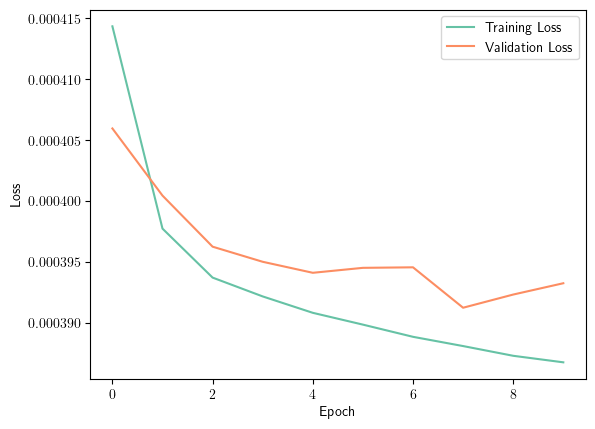

In [33]:
sns.lineplot(train_metrics['losses'], label='Training Loss')
sns.lineplot(val_metrics['losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("losses_epochs.png", dpi=300)

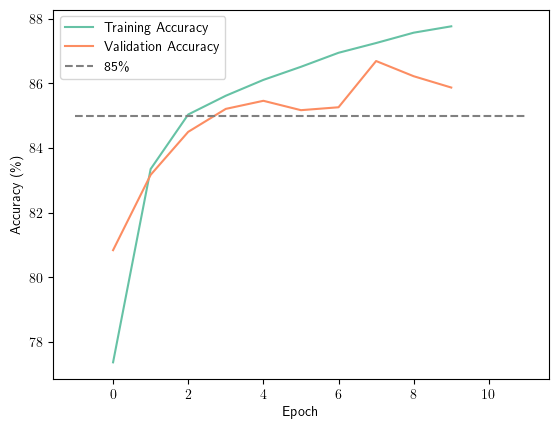

In [46]:
sns.lineplot(train_metrics['accuracies'], label='Training Accuracy')
sns.lineplot(val_metrics['accuracies'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel(r'Accuracy (\%)')
# line at y = 85
plt.hlines(y=[85], xmin=-1, xmax=N_EPOCHS + 1, label = r"85\%", colors="gray", linestyles='dashed')
plt.legend()
plt.savefig("accuracy_epochs.png", dpi=300)